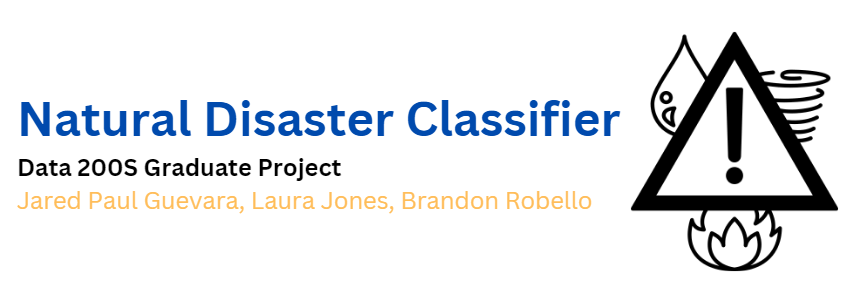


# Rebalancing Task B Dataset


In [29]:
def visualize_feature_distribution(feature_df, disaster_type):
    """
    Visualize the distribution of the summary statistics for each dataset.

    Args:
        feature_df (DataFrame): DataFrame where each row is a feature vector and each column is a feature.
    """
    feature_names = feature_df.columns

    for feature_name in feature_names:
        plt.figure(figsize=(10, 6))
        sns.histplot(feature_df[feature_name], kde=True, bins=20)
        plt.title(f'Distribution of {feature_name} of {disaster_type}')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.show()

def label_dist(disaster, labels):
    # Print statements of min and max
    print(f"Value counts for labels in {disaster} :\n{pd.Series(labels).value_counts().sort_index()}")

    # Create a histogram for label distribution with bins for each label
    plt.hist(labels, bins=[0, 1, 2, 3, 4], align='left', color='green', alpha=0.7)
    plt.title(f'Damage Label Distribution of {disaster}')
    plt.xlabel('Damage Labels')
    plt.ylabel('Frequency')
    plt.xticks([0, 1, 2, 3])  # Set x-ticks to correspond to the discrete labels

    # Adjust the layout
    plt.tight_layout()
    plt.show()

## Observe Training Set Label Distribution


`task_2_df` head:


,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,gabor_7_var,...,gabor_3_var,gabor_11_var,gabor_1_var,gabor_2_var,gabor_10_var,gabor_8_var,gabor_0_var,area of red pixels at 150 threshold,area of green pixels at 150 threshold,area of blue pixels at 150 threshold
0,[[[ 58 94 83]\n [ 60 97 86]\n [ 61 98 ...,hurricane-matthew,3,65,54,0.830769,3510,94.020703,9.486493,1.449397e-05,...,0.000132,0.000122,0.001399,0.000016,0.000019,0.000184,0.000149,0.031054,0.055840,0.042450
1,[[[150 177 183]\n [147 174 182]\n [153 180 1...,hurricane-matthew,0,67,105,1.567164,7035,106.040938,6.510007,2.284809e-07,...,0.000179,0.000073,0.003852,0.000029,0.000005,0.000064,0.000160,0.078323,0.236532,0.243923
2,[[[ 59 81 75]\n [ 53 75 69]\n [ 47 68 ...,hurricane-matthew,1,54,56,1.037037,3024,117.725198,9.884637,2.858254e-05,...,0.000296,0.000342,0.005609,0.000061,0.000076,0.000447,0.000344,0.206349,0.209656,0.208333


`X_train'.columns:


Index(['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int',
       'lbp_var', 'gabor_7_var', 'gabor_6_var', 'lbp_mean', 'sobel_mean',
       'gabor_5_var', 'gabor_4_var', 'sobel_var', 'gabor_9_var', 'gabor_3_var',
       'gabor_11_var', 'gabor_1_var', 'gabor_2_var', 'gabor_10_var',
       'gabor_8_var', 'gabor_0_var', 'area of red pixels at 150 threshold',
       'area of green pixels at 150 threshold',
       'area of blue pixels at 150 threshold'],
      dtype='object')

Value counts for labels in hurricane-matthew :
label
0    2138
1    4190
2    1217
3    1375
Name: count, dtype: int64


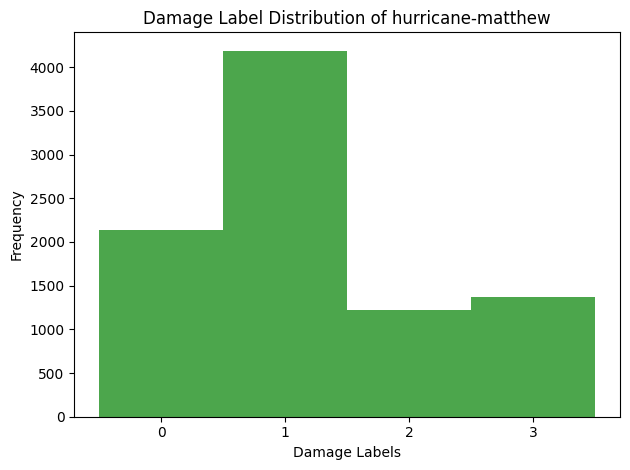

In [30]:
# Save Disaster of interest for task B
disaster = 'hurricane-matthew'

# Get dataset for hurricane-matthew
task_2_df = pd.read_csv('../data/task-data/task-2.csv')

print("`task_2_df` head:")
display(task_2_df.head(3))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(task_2_df.iloc[:,3:], task_2_df.iloc[:,2],
                                                    test_size=0.2, random_state=42)

print("`X_train'.columns:")
display(X_train.columns)

# Visualize Distribution
label_dist(disaster, y_train)

Value counts for labels in hurricane-matthew :
label
0    1217
1    1217
2    1217
3    1217
Name: count, dtype: int64


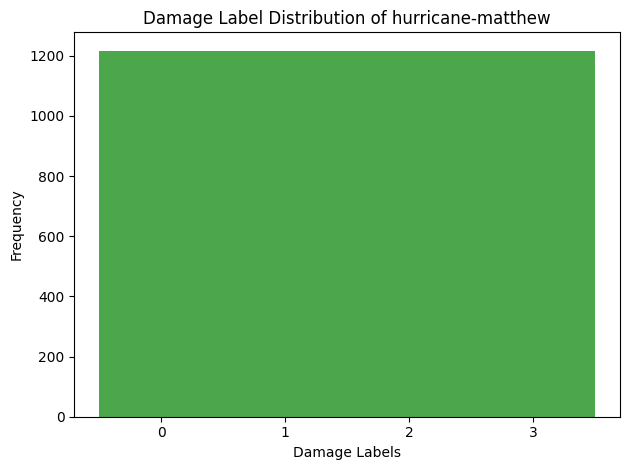

In [31]:
### RUS
from imblearn.under_sampling import RandomUnderSampler
# Initialize the random under-sampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_rus_resampled)

Value counts for labels in hurricane-matthew :
label
0    4190
1    4190
2    4190
3    4190
Name: count, dtype: int64


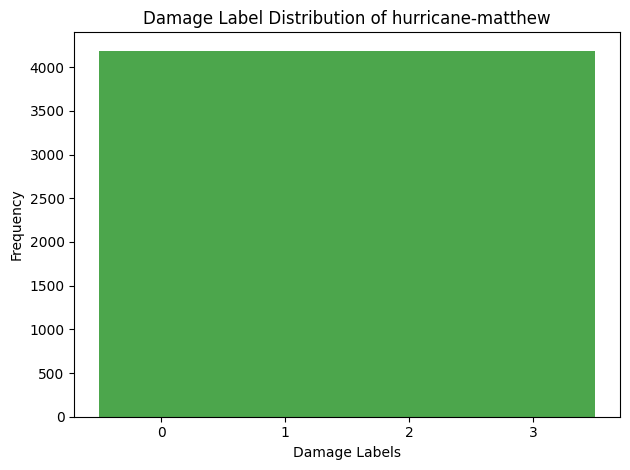

In [32]:
### ROS
from imblearn.over_sampling import RandomOverSampler

# Initialize the over-sampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_ros_resampled)

## Random forest with Undersampled dataset


Accuracy: 0.4988794262662483
              precision    recall  f1-score   support

           0       0.43      0.60      0.50       493
           1       0.66      0.42      0.52      1046
           2       0.28      0.39      0.33       327
           3       0.59      0.67      0.63       365

    accuracy                           0.50      2231
   macro avg       0.49      0.52      0.49      2231
weighted avg       0.54      0.50      0.50      2231



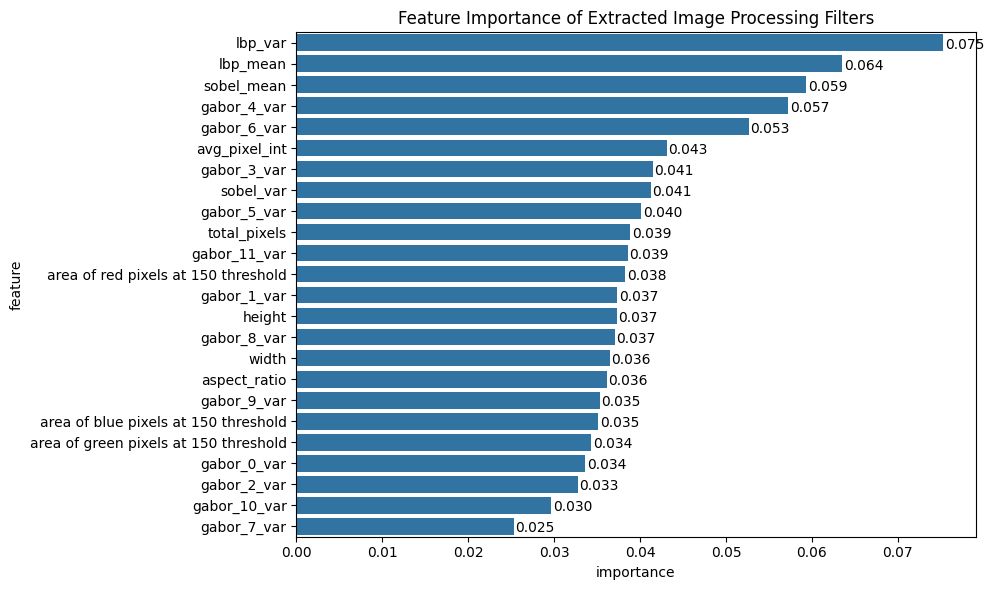

In [36]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the classifier
rf_classifier.fit(X_rus_resampled, y_rus_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_test)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_rus_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

## Random forest with Oversampled dataset


Accuracy: 0.5705961452263559
              precision    recall  f1-score   support

           0       0.47      0.55      0.51       493
           1       0.64      0.67      0.65      1046
           2       0.39      0.24      0.29       327
           3       0.62      0.61      0.62       365

    accuracy                           0.57      2231
   macro avg       0.53      0.52      0.52      2231
weighted avg       0.56      0.57      0.56      2231



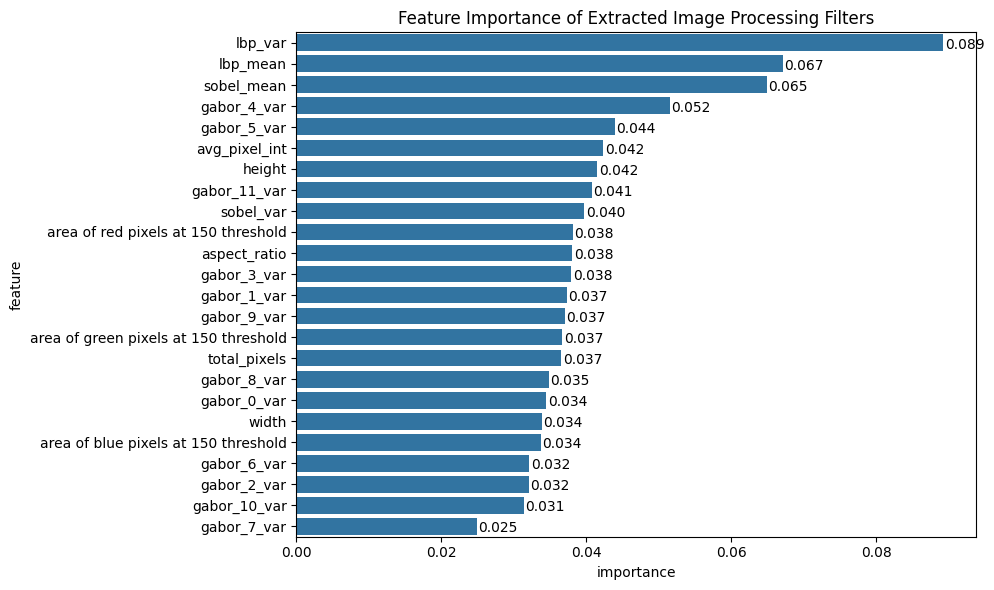

In [35]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the classifier
rf_classifier.fit(X_ros_resampled, y_ros_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_test)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_rus_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

# SMOTE


Value counts for labels in hurricane-matthew :
label
0    4190
1    4190
2    4190
3    4190
Name: count, dtype: int64


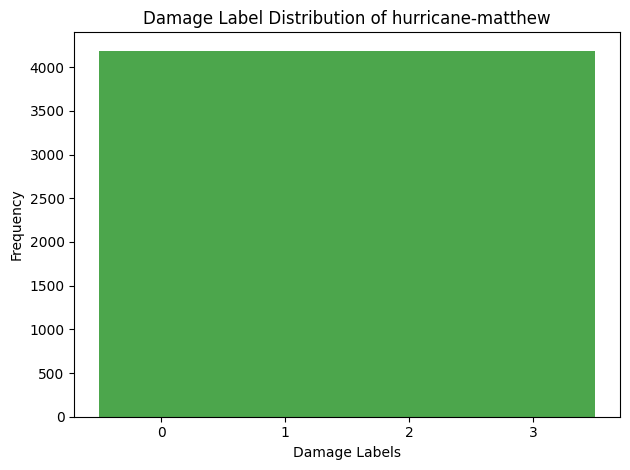

In [40]:
### SMOTE
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset using SMOTE
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_smote_resampled)

Accuracy: 0.5800089645898701
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       493
           1       0.68      0.60      0.64      1046
           2       0.35      0.35      0.35       327
           3       0.61      0.72      0.66       365

    accuracy                           0.58      2231
   macro avg       0.54      0.56      0.55      2231
weighted avg       0.59      0.58      0.58      2231



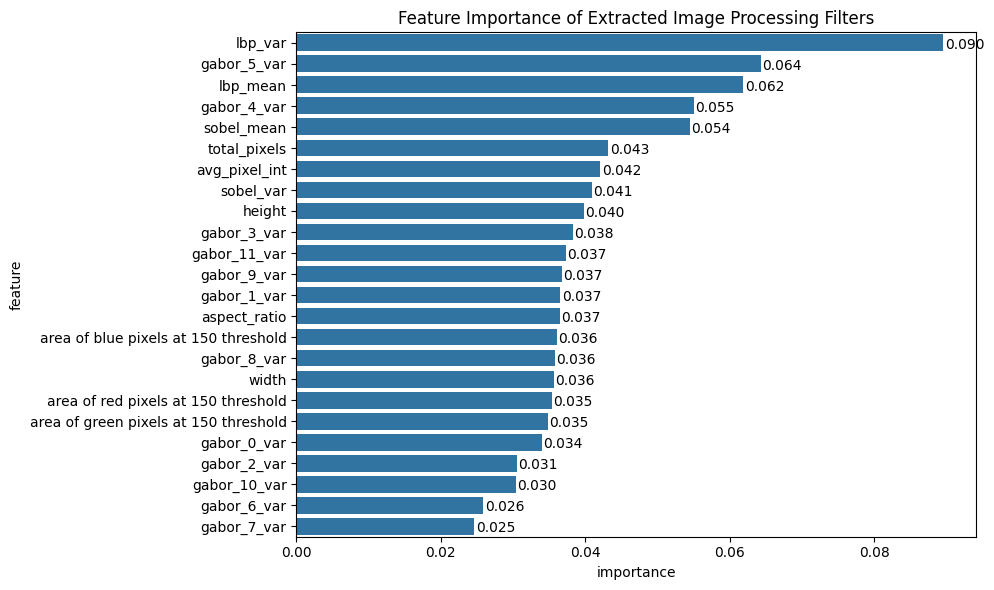

In [41]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_smote_resampled, y_smote_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_smote_resampled)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_smote_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

# ADASYN


Value counts for labels in hurricane-matthew :
label
0    4214
1    4190
2    4226
3    4377
Name: count, dtype: int64


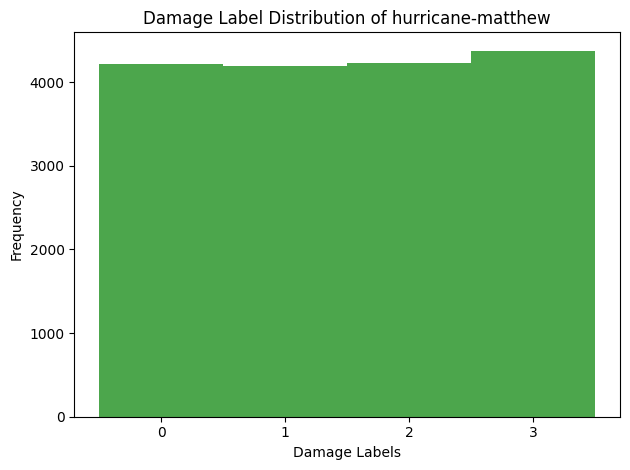

In [43]:
# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Resample the dataset using ADASYN
X_adasyn_resampled, y_adasyn_resampled = adasyn.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_adasyn_resampled)

Accuracy: 0.5791125056028686
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       493
           1       0.67      0.61      0.64      1046
           2       0.36      0.34      0.35       327
           3       0.61      0.72      0.66       365

    accuracy                           0.58      2231
   macro avg       0.54      0.56      0.55      2231
weighted avg       0.58      0.58      0.58      2231



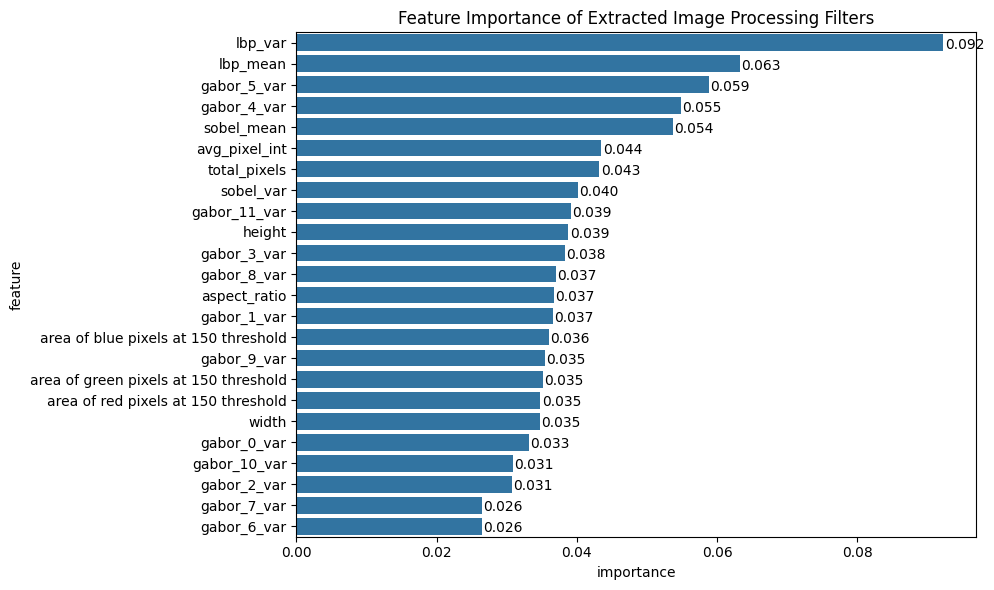

In [44]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_adasyn_resampled, y_adasyn_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_adasyn_resampled)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_adasyn_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()